# Attention Branch Network (ABN)

---

## 目的
ABNの構造を理解する.

ABNを用いてCIFAR-10データセットに対する物体認識を行う．

## Attention Branch Network (ABN)
ABNとは，Attention機構により推論時における注視領域の可視化と，画像認識の高精度化ができるネットワークです．
02_CAM.ipynbで使用したClass Activation Mapping (CAM) は，CNNが推論時に着目した領域をAttention mapとして可視化できる一方で，最後の畳み込み層の後のGlobal Average Pooling (GAP) によって特徴マップの空間的な情報が削除されることによる認識精度の低下が問題となっていました．
ABNでは，ネットワークの判断根拠であるAttention mapを認識処理に用いることで説明性の高いAttention mapの獲得と認識精度の高精度化を実現しました．
ABNは入力画像から特徴マップを抽出
するFeature extractor，Attention mapを出力するAttention branch，Attention mapにより重み付けされた特徴マップを用いて最終的な認識結果を出力するPerception branchの3つのモジュールから構成されています．Attention branchで得られるAttention mapはネットワークが推論時に注視した領域を示しており，Feature extractorで得られた特徴マップに重み付けされます．これにより，Perception branchにおいて特定の領域の特徴に対して，重点的に学習することができます．学習時は，以下の式よりAttention branchとPerception branchの学習誤差を用いてネットワークを学習します．ここで，$x$は入力画像，$Latt(x)$はAttention branch の学習誤差，$Lper(x)$ はPerception branchの学習誤差を示します．

$$Lall(x) = Latt(x) + Lper(x)$$

### Attention branch
Attention branchは，畳み込み層とGAPから構成されており，Attention mapを出力するモジュールです．Attention branchでは，GAPの2層前の特徴マップに対し，$1×1$の重みフィルタを畳み込むことでAttention mapを獲得します．

### Perception branch
Perception branchは，得られたAttention mapから最終的な認識結果を出力します．

![ABN](http://mprg.jp/wp/wp-content/uploads/2019/06/ABN.png)




## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
今回は，機械学習ライブラリであるPytorchを使用します．
PyTorchとは，Python向けのオープンソース機械学習ライブラリで，Facebookに開発されました．

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchsummary

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．
下記のコードを実行してGPU情報を確認します． GPUの確認を行うためには，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPytorchで行うことが可能です． CPUとなっている場合は，上記に記載している手順にしたがって，設定を変更してください．

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
cudnn.benchmark = True
print('Use CUDA:', use_cuda)

Use CUDA: True


下記のコードを実行してGPU情報を確認します．



In [36]:
!nvidia-smi

Thu Oct  1 17:08:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    929MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 使用するデータセット

### データセット
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

### データセットのダウンロードと読み込み
実験に使用するCIFAR-10データセットを読み込みます．
１回の誤差を算出するデータ数 (ミニバッチサイズ) は，64とします．
まず，CIFAR-10データセットをダウンロードします．
次に，ダウンロードしたデータセットを読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです． また，画像の一部にマスク処理をかけるRandom Erasingも行います．

In [37]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=20)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=20)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### CIFAR-10データセットの表示
CIFAR-10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています． これは32x32ピクセルのカラー画像という意味になります．



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


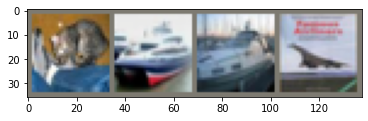

  cat  ship  ship plane


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg.transpose((1,2,0))  * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465])  # unnormalize
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## ネットワークモデルの定義
次に，ABNを定義します．
今回は，ResNetにABNを導入したモデル (ResNet-ABN) を使用します．ResNet-ABNの層の深さ (depth) は，20層に設定します．

In [39]:
import torch.nn as nn
import torch.nn.functional as F
import math


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet_ABN(nn.Module):
    def __init__(self, depth, num_classes=10):
        super(ResNet_ABN, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        block_name = 'Bottleneck' if depth >=44 else 'BasicBlock'
        if block_name.lower() == 'basicblock':
            assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2, e.g. 20, 32, 44'
            n = (depth - 2) // 6
            block = BasicBlock
        elif block_name.lower() == 'bottleneck':
            assert (depth - 2) % 9 == 0, 'When use bottleneck, depth should be 9n+2, e.g. 47, 56, 110, 1199'
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            raise ValueError('block_name shoule be Basicblock or Bottleneck')

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n, down_size=True)
        self.layer2 = self._make_layer(block, 32, n, stride=2, down_size=True)

        self.att_layer3 = self._make_layer(block, 64, n, stride=1, down_size=False)
        self.bn_att = nn.BatchNorm2d(64 * block.expansion)
        self.att_conv   = nn.Conv2d(64 * block.expansion, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.bn_att2 = nn.BatchNorm2d(num_classes)
        self.att_conv2  = nn.Conv2d(num_classes, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.att_conv3  = nn.Conv2d(num_classes, 1, kernel_size=1, padding=0,
                               bias=False)
        self.bn_att3 = nn.BatchNorm2d(1)
        self.att_gap = nn.AvgPool2d(16)
        self.sigmoid = nn.Sigmoid()

        self.layer3 = self._make_layer(block, 64, n, stride=2, down_size=True)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        # print(block, n)
        # self.att_layer3 = self._make_layer(block, 64, n, stride=1)
        # self.att_conv   = nn.Conv2d(64, num_classes, kernel_size=3, padding=1,
        #                        bias=False)
        # self.att_gap = nn.AvgPool2d(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, down_size=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        if down_size:
            self.inplanes = planes * block.expansion
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
        else:
            inplanes = planes * block.expansion
            for i in range(1, blocks):
                layers.append(block(inplanes, planes))

            return nn.Sequential(*layers)


    def forward(self, x):

        # feature extractor
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16

        # attention branch
        ax = self.bn_att(self.att_layer3(x))
        ax = self.relu(self.bn_att2(self.att_conv(ax)))
        bs, cs, ys, xs = ax.shape
        self.att = self.sigmoid(self.bn_att3(self.att_conv3(ax)))
        ax = self.att_conv2(ax)
        ax = self.att_gap(ax)
        ax = ax.view(ax.size(0), -1)

        # perception branch
        rx = x * self.att
        rx = rx + x
        rx = self.layer3(rx)  # 8x8
        rx = self.avgpool(rx)
        rx = rx.view(rx.size(0), -1)
        rx = self.fc(rx)

        return ax, rx, self.att

depth = 20 # e.g. 20, 32, 44, 47, 56, 110, 1199
model = ResNet_ABN(depth)
model.to(device)

ResNet_ABN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

## 損失関数と最適化手法の定義
学習に使用する損失関数と最適化手法を定義します．
各更新において，学習用データと教師データをそれぞれ`inputs`と`targets`とします．
学習モデルに`inputs`を与えて，Attention branchの出力，Perception branchの出力，Attention mapを取得します．
Attention branchの出力及び，Perception branchの出力と教師ラベル`targets`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
最適化手法には，確率的勾配降下法 (stochastic gradient descent: SGD) を用いて学習します．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．


In [40]:
import torch.optim as optim
from torch.optim import SGD, lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=5e-4)
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1) # 50 < 75

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## 学習
学習エポック数を15とします．
CIFAR-10の学習データサイズを取得し，1エポック内における更新回数を求めます．
1エポック学習するごとに学習したモデルを評価し，最も精度の高いモデルが保存されます．

In [41]:
epochs = 15
best_acc = 0  # best test accuracy

for epoch in range(epochs):
    #scheduler.step()
    train_running_loss = 0.0
    train_running_acc = 0.0

    # training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        att_outputs, per_outputs, _ = model(inputs)
        att_loss = criterion(att_outputs, targets)
        per_loss = criterion(per_outputs, targets)
        loss = att_loss + per_loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = per_outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # print statistics
        train_running_loss += loss
        train_running_acc += 100.*correct/total
        count += 1

    print('[Epoch %d] Train Loss: %.5f | Train Acc: %.3f%%'
                  % (epoch + 1, train_loss/count, train_running_acc/count))

    # testing
    model.eval() 
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_acc = 0.0
        test_loss = 0
        correct = 0
        total = 0
        count = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            _, outputs, attention = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print statistics
            test_running_loss += loss
            test_running_acc += 100.*correct/total
            count += 1

        print('Test Loss: %.5f | Test Acc: %.3f%%'
                      % (test_loss/count, test_running_acc/count))
        
    # save model
    if test_running_acc/count > best_acc:
        best_acc = max(test_running_acc/count, best_acc)
        PATH = './cifar_net.pth'
        torch.save(model.state_dict(), PATH)
    
print('Finished Training')

[Epoch 1] Train Loss: 4.12145 | Train Acc: 20.134%
Test Loss: 1.72217 | Test Acc: 34.789%
[Epoch 2] Train Loss: 3.61171 | Train Acc: 34.235%
Test Loss: 1.56823 | Test Acc: 40.988%
[Epoch 3] Train Loss: 3.29495 | Train Acc: 39.864%
Test Loss: 1.45483 | Test Acc: 46.233%
[Epoch 4] Train Loss: 3.01738 | Train Acc: 45.073%
Test Loss: 1.35577 | Test Acc: 50.429%
[Epoch 5] Train Loss: 2.82524 | Train Acc: 49.126%
Test Loss: 1.32854 | Test Acc: 51.931%
[Epoch 6] Train Loss: 2.68791 | Train Acc: 51.485%
Test Loss: 1.29840 | Test Acc: 53.477%
[Epoch 7] Train Loss: 2.55387 | Train Acc: 54.439%
Test Loss: 1.13658 | Test Acc: 59.880%
[Epoch 8] Train Loss: 2.43956 | Train Acc: 57.186%
Test Loss: 1.23316 | Test Acc: 56.636%
[Epoch 9] Train Loss: 2.33772 | Train Acc: 58.377%
Test Loss: 1.11909 | Test Acc: 60.609%
[Epoch 10] Train Loss: 2.26283 | Train Acc: 59.932%
Test Loss: 1.02539 | Test Acc: 63.730%
[Epoch 11] Train Loss: 2.17743 | Train Acc: 61.611%
Test Loss: 1.03598 | Test Acc: 63.800%
[Epoch 1

##テスト
学習したネットワークのテストデータに対する認識率の確認を行います．
まず，学習したネットワークを評価するために保存したモデルをロードします．

In [42]:
depth = 20 #e.g. 20, 32, 44, 47, 56, 110, 1199
model = ResNet_ABN(depth)
model.to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

次に，学習したネットワークを用いて，テストデータに対する認識率の確認を行います．
`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します． これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です． また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [43]:
model.eval()
running_loss = 0.0
running_acc = 0.0
test_loss = 0
correct = 0
total = 0
count = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        _, outputs, attention = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        running_loss += loss
        running_acc += 100.*correct/total
        count += 1

    print('Test Loss: %.5f | Test Acc: %.3f%%'
                  % (test_loss/count, running_acc/count))

Test Loss: 0.89613 | Test Acc: 69.198%


## Attention mapの可視化
Attention mapを可視化して，ネットワークの判断根拠を確認してみます．
再度，実行することで他のテストサンプルに対するAttention mapを可視化することができます．
pred (prediction) は認識結果，conf (confidence) は認識結果に対する信頼度を示しています．

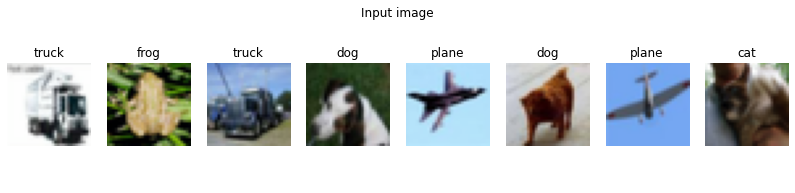

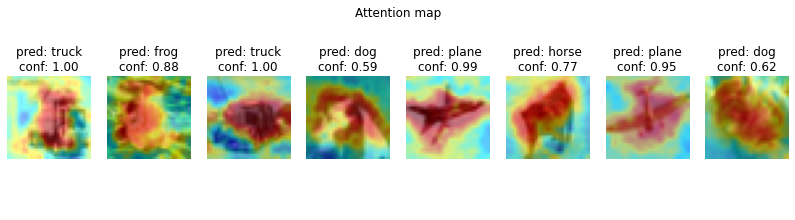

In [50]:
import cv2
from ipykernel import kernelapp as app

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=True, num_workers=20)

classes_list = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

softmax = nn.Softmax(dim=1)

def min_max(x, axis=None):
    x_min = x.min(axis=axis, keepdims=True)
    x_max = x.max(axis=axis, keepdims=True)
    return (x - x_min) / (x_max - x_min)

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        _, outputs, attention = model(inputs)
        outputs = softmax(outputs)
        conf_data = outputs.data.topk(1, 1, True, True)
        _, predicted = outputs.max(1)
        c_att = attention.data.cpu()
        c_att = c_att.numpy()
        d_inputs = inputs.data.cpu()
        d_inputs = d_inputs.numpy()

        in_b, in_c, in_y, in_x = inputs.shape
        v_list = []
        att_list = []
        for item_img, item_att in zip(d_inputs, c_att):
            v_img = ((item_img.transpose((1, 2, 0)) * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465]) * 255
            #v_img = v_img[:, :, ::-1]
            resize_att = cv2.resize(item_att[0], (in_x, in_y))
            #resize_att = min_max(resize_att)
            resize_att *= 255.

            v_img = np.uint8(v_img)
            resize_att = np.uint8(resize_att)
            jet_map = cv2.applyColorMap(resize_att, cv2.COLORMAP_JET)
            jet_map = cv2.addWeighted(v_img, 0.5, jet_map, 0.5, 0)
            v_list.append(v_img)
            att_list.append(jet_map)
        break

# Show attention map
cols = 8
rows = 1

fig = plt.figure(figsize=(14, 3.0))
plt.title('Input image')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        cls = targets[c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        plt.title('{}'.format(classes_list[cls]))
        ax.imshow(v_list[cols * r + c])
        ax.set_axis_off()
plt.show()

fig = plt.figure(figsize=(14, 3.5))
plt.title('Attention map')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        pred = predicted[c].item()
        conf = conf_data[0][c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(att_list[cols * r + c])
        plt.title('pred: {}\nconf: {:.2f}'.format(classes_list[pred], conf))
        ax.set_axis_off()
plt.show()

## 課題
1. エポック数やミニバッチサイズを変えて実験し，精度とAttention mapの変化を確認しましょう．

In [45]:
#ここにコードを書く